# Dependencies

In [1]:
# Install dependencies for Google Colab.
# If you want to run this notebook on your own machine, you can skip this cell
!pip install dm-haiku
!pip install einops

!mkdir /content/perceiver
!touch /content/perceiver/__init__.py
!wget -O /content/perceiver/io_processors.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/io_processors.py
!wget -O /content/perceiver/perceiver.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/perceiver.py
!wget -O /content/perceiver/position_encoding.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/position_encoding.py

     |████████████████████████████████| 284 kB 5.0 MB/s 
--2021-10-09 02:08:19--  https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/io_processors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29359 (29K) [text/plain]
Saving to: ‘/content/perceiver/io_processors.py’

/content/perceiver/ 100%[===================>]  28.67K  --.-KB/s    in 0.001s  

2021-10-09 02:08:20 (20.4 MB/s) - ‘/content/perceiver/io_processors.py’ saved [29359/29359]

--2021-10-09 02:08:20--  https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/perceiver.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserc

# Imports

In [2]:
import functools
import itertools
import pickle

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import cv2
import imageio

from perceiver import perceiver, io_processors

# Creating Model

In [3]:
FLOW_SCALE_FACTOR = 20
# The network assumes images are of the following size
TRAIN_SIZE = (368, 496)

def optical_flow(images):
  """Perceiver IO model for optical flow.

  Args:
    images: Array of two stacked images, of shape [B, 2, H, W, C]
  Returns:
    Optical flow field, of shape [B, H, W, 2].
  """
  input_preprocessor = io_processors.ImagePreprocessor(
      position_encoding_type='fourier',
      fourier_position_encoding_kwargs=dict(
          num_bands=64,
          max_resolution=TRAIN_SIZE,
          sine_only=False,
          concat_pos=True,
      ),
      n_extra_pos_mlp=0,
      prep_type='patches',
      spatial_downsample=1,
      conv_after_patching=True,
      temporal_downsample=2)

  encoder = encoder = perceiver.PerceiverEncoder(
      num_self_attends_per_block=24,
      # Weights won't be shared if num_blocks is set to 1.
      num_blocks=1,
      z_index_dim=2048,
      num_cross_attend_heads=1,
      num_z_channels=512,
      num_self_attend_heads=16,
      cross_attend_widening_factor=1,
      self_attend_widening_factor=1,
      dropout_prob=0.0,
      z_pos_enc_init_scale=0.02,
      cross_attention_shape_for_attn='kv',
      name='perceiver_encoder')

  decoder = perceiver.FlowDecoder(
      TRAIN_SIZE,
      rescale_factor=100.0,
      use_query_residual=False,
      output_num_channels=2,
      output_w_init=jnp.zeros,
      # We query the decoder using the first frame features
      # rather than a standard decoder position encoding.
      position_encoding_type='fourier',
      fourier_position_encoding_kwargs=dict(
          concat_pos=True,
          max_resolution=TRAIN_SIZE,
          num_bands=64,
          sine_only=False
      )
  )

  model = perceiver.Perceiver(
      input_preprocessor=input_preprocessor,
      encoder=encoder,
      decoder=decoder,
      output_postprocessor=None)

  return model(io_processors.patches_for_flow(images),
               is_training=False) * FLOW_SCALE_FACTOR


optical_flow = hk.transform(optical_flow)

# Compute Flow Between Images

In [4]:

# If you encounter GPU memory errors while running the function below,
# you can run it on the CPU instead:
# _apply_optical_flow_model = jax.jit(optical_flow.apply, backend="cpu")
_apply_optical_flow_model = jax.jit(optical_flow.apply)

def compute_grid_indices(image_shape, patch_size=TRAIN_SIZE, min_overlap=20):
  if min_overlap >= TRAIN_SIZE[0] or min_overlap >= TRAIN_SIZE[1]:
    raise ValueError(
        f"Overlap should be less than size of patch (got {min_overlap}"
        f"for patch size {patch_size}).")
  ys = list(range(0, image_shape[0], TRAIN_SIZE[0] - min_overlap))
  xs = list(range(0, image_shape[1], TRAIN_SIZE[1] - min_overlap))
  # Make sure the final patch is flush with the image boundary
  ys[-1] = image_shape[0] - patch_size[0]
  xs[-1] = image_shape[1] - patch_size[1]
  return itertools.product(ys, xs)

def compute_optical_flow(params, rng, img1, img2, grid_indices,
                       patch_size=TRAIN_SIZE):
  """Function to compute optical flow between two images.

  To compute the flow between images of arbitrary sizes, we divide the image
  into patches, compute the flow for each patch, and stitch the flows together.

  Args:
    params: model parameters
    rng: jax.random.PRNGKey, not used in this model
    img1: first image
    img2: second image
    grid_indices: indices of the upper left corner for each patch.
    patch_size: size of patch, should be TRAIN_SIZE.
  """
  imgs = jnp.stack([img1, img2], axis=0)[None]
  height = imgs.shape[-3]
  width = imgs.shape[-2]

  if height < patch_size[0]:
    raise ValueError(
        f"Height of image (shape: {imgs.shape}) must be at least {patch_size[0]}."
        "Please pad or resize your image to the minimum dimension."
    )
  if width < patch_size[1]:
    raise ValueError(
        f"Width of image (shape: {imgs.shape}) must be at least {patch_size[1]}."
        "Please pad or resize your image to the minimum dimension."
    )

  flows = 0
  flow_count = 0

  for y, x in grid_indices:
    inp_piece = imgs[..., y : y + patch_size[0],
                     x : x + patch_size[1], :]
    flow_piece = _apply_optical_flow_model(params, rng, inp_piece)
    weights_x, weights_y = jnp.meshgrid(
        jnp.arange(patch_size[1]), jnp.arange(patch_size[0]))

    weights_x = jnp.minimum(weights_x + 1, patch_size[1] - weights_x)
    weights_y = jnp.minimum(weights_y + 1, patch_size[0] - weights_y)
    weights = jnp.minimum(weights_x, weights_y)[jnp.newaxis, :, :,
                                                jnp.newaxis]
    padding = [(0, 0), (y, height - y - patch_size[0]),
               (x, width - x - patch_size[1]), (0, 0)]
    flows += jnp.pad(flow_piece * weights, padding)
    flow_count += jnp.pad(weights, padding)

  flows /= flow_count
  return flows

# Load Params From Checkpoint

In [5]:
!wget -O optical_flow_checkpoint.pystate https://storage.googleapis.com/perceiver_io/optical_flow_checkpoint.pystate

rng = jax.random.PRNGKey(42)
with open("optical_flow_checkpoint.pystate", "rb") as f:
  params = pickle.loads(f.read())

state = {}

--2021-10-09 02:09:28--  https://storage.googleapis.com/perceiver_io/optical_flow_checkpoint.pystate
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.218.128, 108.177.13.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164271840 (157M) [application/octet-stream]
Saving to: ‘optical_flow_checkpoint.pystate’

optical_flow_checkp 100%[===================>] 156.66M   181MB/s    in 0.9s    

2021-10-09 02:09:29 (181 MB/s) - ‘optical_flow_checkpoint.pystate’ saved [164271840/164271840]



In [6]:
# Download two example frames from the Sintel dataset.
# These files are obtained from the Sintel dataset test split,
# downloaded from http://sintel.is.tue.mpg.de/downloads.
# They correspond to MPI-Sintel-testing/test/clean/cave_3/frame_0001.png
# and MPI-Sintel-testing/test/clean/cave_3/frame_0002.png.
#
# Citation for Sintel dataset:
# D. J. Butler, J. Wulff, G. B. Stanley, and M. J. Black.
# A naturalistic open source movie for optical flow evaluation.
# European Conf. on Computer Vision (ECCV), 2012.
# https://files.is.tue.mpg.de/black/papers/ButlerECCV2012.pdf
#
# The Sintel images are originally generated for the Durian Open Movie project
# and are licensed under the Creative Commons Attribution 3.0 license (https://durian.blender.org/sharing/).
# The images are copyrighted by the Blender Foundation (https://durian.blender.org).


!wget -O sintel_frame1.png https://storage.googleapis.com/perceiver_io/sintel_frame1.png
!wget -O sintel_frame2.png https://storage.googleapis.com/perceiver_io/sintel_frame2.png

with open("sintel_frame1.png", "rb") as f:
  im1 = imageio.imread(f)
with open("sintel_frame2.png", "rb") as f:
  im2 = imageio.imread(f)

--2021-10-09 02:09:44--  https://storage.googleapis.com/perceiver_io/sintel_frame1.png
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 710411 (694K) [application/octet-stream]
Saving to: ‘sintel_frame1.png’

sintel_frame1.png   100%[===================>] 693.76K  --.-KB/s    in 0.007s  

2021-10-09 02:09:44 (94.0 MB/s) - ‘sintel_frame1.png’ saved [710411/710411]

--2021-10-09 02:09:44--  https://storage.googleapis.com/perceiver_io/sintel_frame2.png
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 108.177.13.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 712519 (696K) [application/octet-stream]
Saving to: ‘sintel_fr

# Utilities

In [7]:
def normalize(im):
  return im / 255.0 * 2 - 1

def visualize_flow(flow):
  flow = np.array(flow)
  # Use Hue, Saturation, Value colour model 
  hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
  hsv[..., 2] = 255

  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  hsv[..., 0] = ang / np.pi / 2 * 180
  hsv[..., 1] = np.clip(mag * 255 / 24, 0, 255)
  bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  plt.imshow(bgr)

# Optical Flow

In [ ]:
# Divide images into patches, compute flow between corresponding patches
# of both images, and stitch the flows together
grid_indices = compute_grid_indices(im1.shape)
flow = compute_optical_flow(params, rng, normalize(im1), normalize(im2), grid_indices)

# Visualize Optical Flow

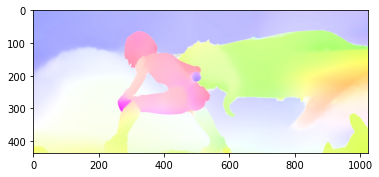

In [11]:
# Visualize the computed flow
visualize_flow(flow[0])